In [1]:
import pandas as pd
import dateutil
import matplotlib.pyplot as plt

In [2]:
dataWithAnnomaly = pd.read_csv("GeneratedDataAnomaly22.csv", index_col = 0)
trainWithoutAnnomaly = pd.read_csv("GeneratedData2.csv")
trainWithoutAnnomaly['timestamp']=trainWithoutAnnomaly['timestamp'].apply(lambda x: dateutil.parser.parse(x))

In [3]:
newD = pd.DataFrame()

In [4]:
newD['value']=trainWithoutAnnomaly['values']
newD['month']=trainWithoutAnnomaly['timestamp'].apply(lambda x: x.month)
newD['dateY']=trainWithoutAnnomaly['timestamp'].apply(lambda x: x.day)
# newD['yearY']=trainWithoutAnnomaly['timestamp'].apply(lambda x: x.year)
newD['hourY']=trainWithoutAnnomaly['timestamp'].apply(lambda x: x.hour)
newD['minY']=trainWithoutAnnomaly['timestamp'].apply(lambda x: x.minute)
newD['secY']=trainWithoutAnnomaly['timestamp'].apply(lambda x: x.second)
newD['target']=newD['value'].shift(-1)

In [5]:
# trainWithoutAnnomaly = trainWithoutAnnomaly.set_index("timestamp")
trainWithoutAnnomaly = pd.read_csv("GeneratedData2.csv", index_col = 0)

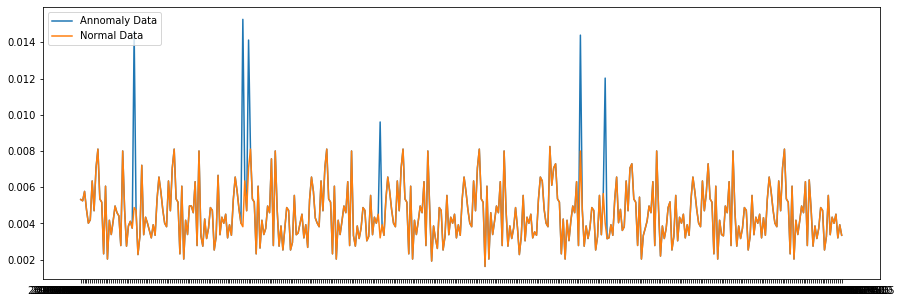

In [6]:
plt.figure(figsize=(15,5))
plt.plot(dataWithAnnomaly[600:1000],label="Annomaly Data")
plt.plot(trainWithoutAnnomaly[600:1000],label="Normal Data")
plt.legend(loc='upper left')

In [7]:
len(dataWithAnnomaly)

150000

In [8]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [9]:
# model2.save("file.pickle")

In [10]:
model2 = SARIMAX(trainWithoutAnnomaly[:1000],order = (1,0,1),seasonal_order = (2,0,0,40)).fit()

C:\Users\cchi\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency 5S will be used.
  % freq, ValueWarning)


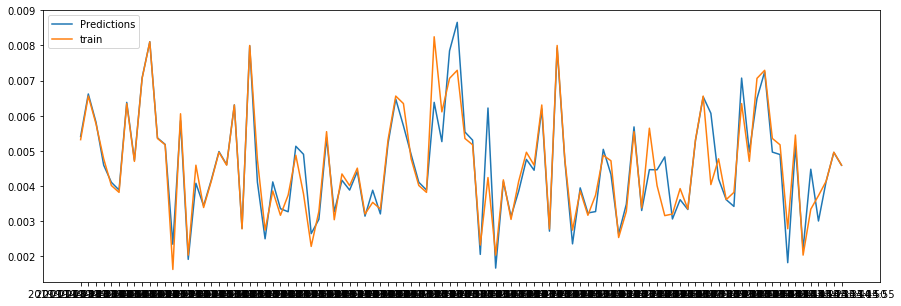

In [159]:
plt.figure(figsize=(15,5))
plt.plot(list(model2.predict())[-200:-100],label="Predictions")
# plt.plot(dataWithAnnomaly[800:900],label="Original")
plt.plot(trainWithoutAnnomaly[800:900],label="train")
plt.legend(loc='upper left')

Text(0.5, 1.0, 'Forecast and Original data')

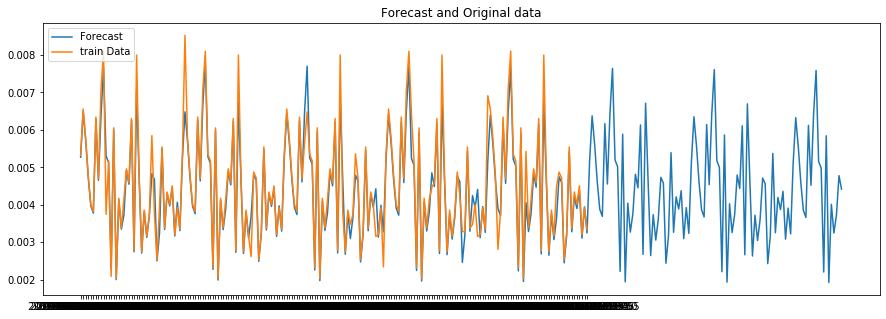

In [15]:
plt.figure(figsize=(15,5))
# plt.plot(dataWithAnnomaly[1000:1300],label="Annomaly Data")
plt.plot(list(model2.forecast(300)),label="Forecast")
plt.plot(trainWithoutAnnomaly[1000:1200],label="train Data")
plt.legend(loc='upper left')
plt.title("Forecast and Original data")

In [145]:
scoresFromArima = model2.forecast(2000).to_numpy()

In [146]:
from tensorflow.keras import Model,applications,activations,layers,Sequential

In [147]:
arimaIn=layers.Input((1,))
modelCInp=layers.Input(shape=(6,))
modelC=layers.Dense(18,activation='relu')(modelCInp)
modelC=layers.Dense(12,activation='relu')(modelC)
modelC=layers.Dense(7,activation='relu')(modelC)
modelC=layers.Dense(3,activation='relu')(modelC)
modelC=layers.Dense(1)(modelC)

modelCAdd=layers.Lambda(lambda x: x[0] + x[1],output_shape=(1,))([modelC,arimaIn])

In [148]:
model = Model([modelCInp,arimaIn],modelCAdd)

In [149]:
model.summary()

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_18 (InputLayer)           [(None, 6)]          0                                            
__________________________________________________________________________________________________
dense_38 (Dense)                (None, 18)           126         input_18[0][0]                   
__________________________________________________________________________________________________
dense_39 (Dense)                (None, 12)           228         dense_38[0][0]                   
__________________________________________________________________________________________________
dense_40 (Dense)                (None, 7)            91          dense_39[0][0]                   
____________________________________________________________________________________________

In [150]:
model.compile(loss='mean_squared_error', optimizer='adam')

In [151]:
cola=['value', 'month', 'dateY', 'hourY', 'minY', 'secY']

In [152]:
model.fit([newD[cola].values[1000:3000],scoresFromArima], newD['target'].values[1000:3000],
          batch_size=12,epochs=30)

Epoch 1/30
2000/2000 [==============================] - 1s 311us/sample - loss: 0.0435
Epoch 2/30
2000/2000 [==============================] - 0s 97us/sample - loss: 1.2169e-05
Epoch 3/30
2000/2000 [==============================] - 0s 103us/sample - loss: 3.7813e-06
Epoch 4/30
2000/2000 [==============================] - 0s 100us/sample - loss: 3.5838e-06
Epoch 5/30
2000/2000 [==============================] - 0s 98us/sample - loss: 3.5833e-06
Epoch 6/30
2000/2000 [==============================] - 0s 93us/sample - loss: 3.5832e-06
Epoch 7/30
2000/2000 [==============================] - 0s 98us/sample - loss: 3.5856e-06
Epoch 8/30
2000/2000 [==============================] - 0s 98us/sample - loss: 3.5848e-06
Epoch 9/30
2000/2000 [==============================] - 0s 97us/sample - loss: 3.5825e-06
Epoch 10/30
2000/2000 [==============================] - 0s 98us/sample - loss: 3.5867e-06
Epoch 11/30
2000/2000 [==============================] - 0s 97us/sample - loss: 3.5912e-06
Epoch 12/

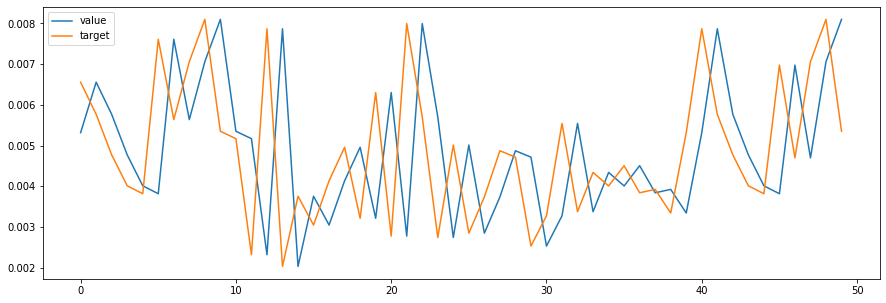

In [153]:
plt.figure(figsize=(15,5))
plt.plot(newD['value'][:50],label="value")
plt.plot(newD['target'][:50],label="target")
plt.legend(loc='upper left')

In [154]:
nnOutput = model.predict([newD[cola].values[1000:2000],scoresFromArima])

Text(0.5, 1.0, 'Forecast and Original data')

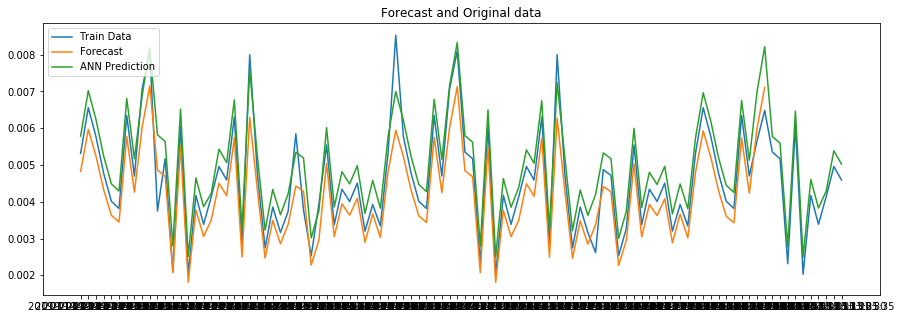

In [161]:
plt.figure(figsize=(15,5))
# plt.plot(dataWithAnnomaly[1000:1100],label="Annomaly Data")
plt.plot(trainWithoutAnnomaly[1000:1100],label="Train Data")
plt.plot(scoresFromArima[:90],label="Forecast")
plt.plot(nnOutput[:100],label="ANN Prediction")
plt.legend(loc='upper left')
plt.title("Forecast and Original data")

In [162]:
scoresFromArima2 = scoresFromArima = model2.forecast(2000).to_numpy()[1000:]

In [163]:
nnOutput2=model.predict([newD[cola].values[2000:3000],scoresFromArima2])

Text(0.5, 1.0, 'Forecast and Original data')

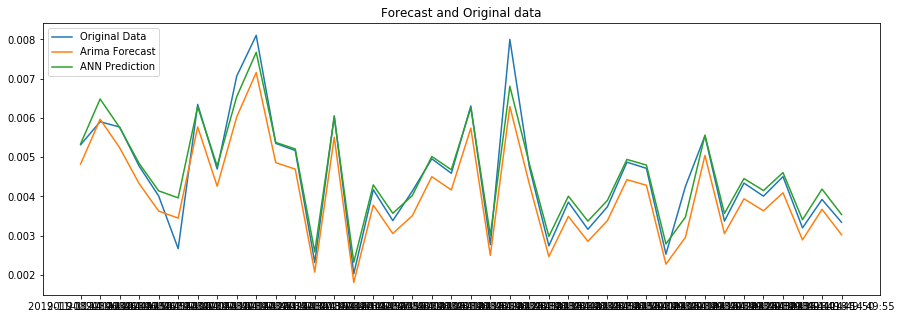

In [169]:
plt.figure(figsize=(15,5))
# plt.plot(dataWithAnnomaly[2000:2030],label="Annomaly Data")
plt.plot(trainWithoutAnnomaly[2000:2040],label="Original Data")
plt.plot(scoresFromArima2[:40],label="Arima Forecast")
plt.plot(nnOutput2[:40],label="ANN Prediction")
plt.legend(loc='upper left')
plt.title("Forecast and Original data")

In [170]:
model.save("Ann.h5")

In [171]:
from nyoka import ArimaToPMML

In [172]:
ArimaToPMML(results_obj = model2,pmml_file_name = "arimaModel.pmml")